In [ ]:
# /* 1. Separate X and y
# 2. Train-Test Split
# 3. Feature Scaling (ONLY on X_train)
# 4. Handle Imbalance (ONLY on training data)
# 5. Train Logistic Regression
# 6. Evaluate using Precision, Recall, F1/


In [70]:
import pandas as pd
import numpy as np

np.random.seed(42)


rows = 9000

data = {
    "income": np.random.normal(50000, 20000, rows),
    "debts": np.random.normal(15000, 10000, rows),
    "credit_score": np.random.randint(300, 850, rows),
    "employment_years": np.random.randint(0, 35, rows),
    "loan_amount": np.random.normal(20000, 15000, rows),
    "payment_history": np.random.randint(0, 6, rows),
    "age": np.random.randint(18, 70, rows),
    "loan_term": np.random.choice([12, 24, 36, 48, 60], rows)
}

df = pd.DataFrame(data)

# ---------- Target Variable ----------
df["creditworthy"] = np.where(
    (df["credit_score"] > 650) &
    (df["payment_history"] <= 1) &
    (df["income"] > df["loan_amount"] / 2),
    1,
    0
)

# ---------- Introduce Missing Values ----------
for col in df.columns:
    df.loc[df.sample(frac=0.08).index, col] = np.nan

# ---------- Messy Data ----------
df.loc[df.sample(frac=0.03).index, "income"] *= -1   # negative income
df.loc[df.sample(frac=0.03).index, "debts"] *= 5     # extreme debts

df.sample(2)

,income,debts,credit_score,employment_years,loan_amount,payment_history,age,loan_term,creditworthy
3135,58860.042609,19340.684872,469.0,11.0,16726.394368,3.0,32.0,60.0,0.0
2758,NaN,19137.542029,379.0,17.0,26065.495292,4.0,57.0,12.0,0.0


HANDLING_INCORRECT_DATA

In [71]:
df['income']  = df['income'].abs()

In [72]:
df[df['income'] < 0]

,income,debts,credit_score,employment_years,loan_amount,payment_history,age,loan_term,creditworthy


In [73]:
cols = [i for i in df.columns]
for i in range(len(df.columns)):
    df[cols[i]] = df[cols[i]].abs()
    

In [74]:
df.sample(2)

,income,debts,credit_score,employment_years,loan_amount,payment_history,age,loan_term,creditworthy
8580,53478.944168,29022.095895,361.0,23.0,32204.782041,1.0,51.0,24.0,0.0
668,3019.396168,5750.741843,725.0,4.0,NaN,1.0,41.0,36.0,0.0


In [75]:
print('income' ,df['income'].mean(),"debths",df['debts'].mean(),"credit_score",df['credit_score'].mean(),"employment_years",df['employment_years'].median(),"loan_amount",df['loan_amount'].median())

income 49984.73253228217 debths 17611.375167424583 credit_score 574.4972222222223 employment_years 17.0 loan_amount 19995.07859304758


In [76]:
df.columns[0]

'income'

HANDLING MISSING DATA

In [77]:
(((df['income'].isnull().sum()/ len(df))*100) *9) 

np.float64(72.0)

In [78]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline



In [79]:
df['debts'].mean(),df['debts'].median()
df['loan_amount'].mean(),df['loan_amount'].median()

(np.float64(21235.532936896278), 19995.07859304758)

In [80]:
df.head(1)

,income,debts,credit_score,employment_years,loan_amount,payment_history,age,loan_term,creditworthy
0,59934.28306,22654.02156,813.0,8.0,15537.525878,3.0,20.0,12.0,NaN


In [81]:
col_tra = ColumnTransformer(
    transformers=[
        ('tr_1',SimpleImputer(strategy='median'),['income','loan_amount']),
        ('tr_2',SimpleImputer(strategy='mean'),['debts','employment_years']),
        ('tr_3',IterativeImputer(),['credit_score','payment_history']),
        ('tr_4',SimpleImputer(strategy='most_frequent'),['age','loan_term']),
    ]
    ,remainder='passthrough'
)

In [82]:
df = pd.DataFrame(col_tra.fit_transform(df),columns=df.columns)

In [83]:
df['creditworthy'].value_counts()

,count
creditworthy,
0.0,7265
1.0,1015


In [84]:
df['creditworthy'].fillna(1,inplace=True)

/tmp/ipython-input-166859299.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['creditworthy'].fillna(1,inplace=True)


In [85]:
df.isnull().sum()

,0
income,0
debts,0
credit_score,0
employment_years,0
loan_amount,0
payment_history,0
age,0
loan_term,0
creditworthy,0


In [86]:
df['employment_years'].mean()

np.float64(17.0493961352657)

In [87]:
# pro = df[df['employment_years'] > df['age']][['employment_years','age']]
# df['age'] = pro['age'] + 18
for i in range(len(df)):
    if df['employment_years'][i] > df['age'][i]:
        df['age'][i] = df['age'][i] + 18
    else:
        pass

/tmp/ipython-input-2594212717.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['age'][i] = df['age'][i] + 18


In [88]:
df[df['employment_years'] > df['age']]

,income,debts,credit_score,employment_years,loan_amount,payment_history,age,loan_term,creditworthy


CORRECTING DATA TYPE OF COLUMNS

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   income            9000 non-null   float64
 1   debts             9000 non-null   float64
 2   credit_score      9000 non-null   float64
 3   employment_years  9000 non-null   float64
 4   loan_amount       9000 non-null   float64
 5   payment_history   9000 non-null   float64
 6   age               9000 non-null   float64
 7   loan_term         9000 non-null   float64
 8   creditworthy      9000 non-null   float64
dtypes: float64(9)
memory usage: 632.9 KB


In [90]:
df['income'].astype('float32').head(1)



,income
0,59934.28125


In [91]:
df['debts'].astype('float32').head(1)


,debts
0,15537.525391


In [92]:
df['credit_score'].astype('float32').head(1)


,credit_score
0,22654.021484


In [93]:
df['employment_years'].astype('float64')
#

,employment_years
0,8.000000
1,17.000000
2,34.000000
3,30.000000
4,23.000000
...,...
8995,17.049396
8996,17.049396
8997,14.000000
8998,6.000000


In [94]:
 df['loan_amount'].astype('float32')


,loan_amount
0,813.0
1,848.0
2,396.0
3,669.0
4,716.0
...,...
8995,693.0
8996,426.0
8997,413.0
8998,824.0


In [95]:
df['age'].astype('int8')
#

,age
0,20
1,65
2,39
3,64
4,66
...,...
8995,22
8996,31
8997,51
8998,27


In [96]:
 df['loan_term'].astype('int8')


,loan_term
0,12
1,12
2,12
3,12
4,36
...,...
8995,24
8996,36
8997,36
8998,36


In [97]:
df['creditworthy'].astype('int8')

,creditworthy
0,1
1,0
2,0
3,0
4,0
...,...
8995,0
8996,1
8997,0
8998,1


In [98]:
df.isnull().sum()

,0
income,0
debts,0
credit_score,0
employment_years,0
loan_amount,0
payment_history,0
age,0
loan_term,0
creditworthy,0


TREATING OUTLIERS

INcome_COLUMN

In [99]:
median = df['income'].median()
median

49874.07773230648

In [100]:
df['income'].describe()

,income
count,9000.000000
mean,49975.880148
std,19131.880423
min,11.885703
25%,37678.214480
50%,49874.077732
75%,62073.252287
max,128524.754129


In [101]:
q1 = df['income'].quantile(0.25)
q3 = df['income'].quantile(0.75)
iqr = q3 - q1

In [102]:
Min_inc = q1 - 1.5 * iqr
Max_inc = q3 + 1.5 * iqr

In [103]:
df['income'] = np.where(
    df['income'] < Min,Min,
    np.where(
        df['income'] > Max,Max,
        df['income']
    )
)

NameError: name 'Min' is not defined

In [ ]:
df.describe()

,income,debts,credit_score,employment_years,loan_amount,payment_history,age,loan_term,creditworthy
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,49921.470219,21136.296589,17611.375167,17.049396,574.497219,2.485785,44.779667,37.993333,0.192778
std,18968.148666,12521.042776,15753.286777,9.729551,153.449288,1.641445,13.338732,17.563966,0.394502
min,1085.657769,1.190926,8.020153,0.000000,300.000000,0.000000,18.000000,12.000000,0.000000
25%,37678.214480,11817.613893,9487.838874,9.000000,449.000000,1.000000,35.000000,24.000000,0.000000
50%,49874.077732,19995.078593,16572.461757,17.049396,574.497219,2.486239,46.000000,36.000000,0.000000
75%,62073.252287,28924.117921,21683.905763,25.000000,700.000000,4.000000,55.000000,60.000000,0.000000
max,98665.808998,81491.754994,243888.412064,34.000000,849.000000,5.000000,69.000000,60.000000,1.000000


<Axes: ylabel='income'>

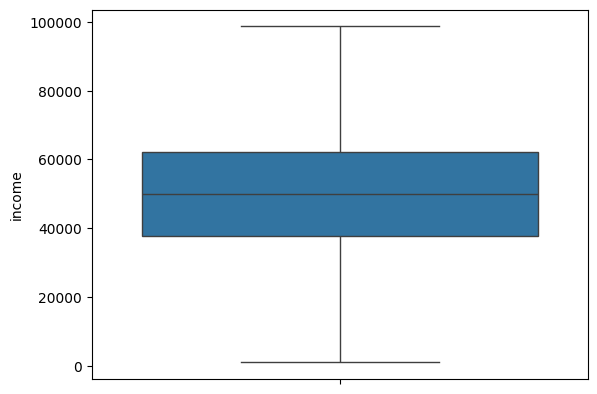

In [ ]:
import seaborn as sns
sns.boxplot(df['income'])

DEBTH_COLUMN

In [ ]:
med = df['debts'].median()
r1 = df['debts'].quantile(0.25)
q3 = df['debts'].quantile(0.75)
iqr = q3 - r1 
Min_deb = r1 - 1.5 * iqr
Max_deb = q3 + 1.5 * iqr

In [ ]:
df['debts'] = np.where(
    df['debts'] < Min_deb,Min_deb,
    np.where(
        df['debts'] > Max_deb,Max_deb,
        df['debts']
    ))

<Axes: ylabel='debts'>

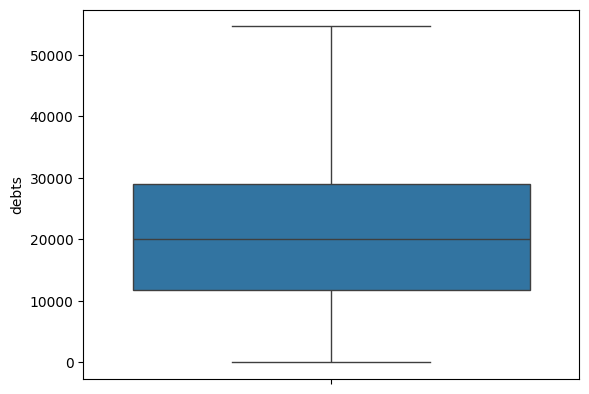

In [ ]:
sns.boxplot(df['debts'])

COLUMN_CREDIT_SCORE

In [ ]:
df['credit_score'].head()

,credit_score
0,22654.021560
1,25734.127024
2,19986.899121
3,4424.976910
4,13445.775675


In [ ]:
med = df['credit_score'].median()
r1 = df['credit_score'].quantile(0.25)
q3 = df['credit_score'].quantile(0.75)
iqr = q3 - r1 
Min_crd = r1 - 1.5 * iqr
Max_crd = q3 + 1.5 * iqr

In [ ]:
df['credit_score'] = np.where(
    df['credit_score'] < Min_crd,Min_crd,
    np.where(
        df['credit_score'] > Max_crd,Max_crd,
        df['credit_score']
    ))

<Axes: ylabel='credit_score'>

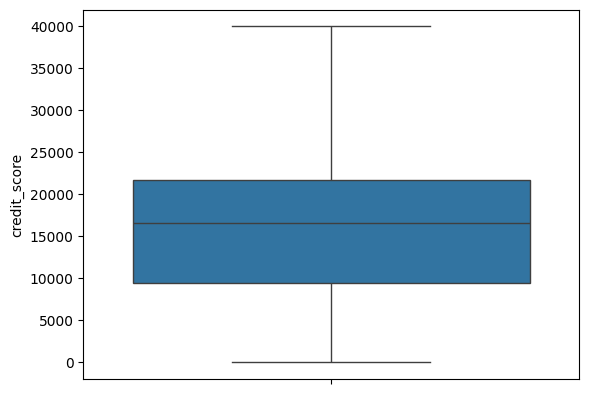

In [ ]:
sns.boxplot(df['credit_score'])

In [ ]:
med = df['employment_years'].median()
r1 = df['employment_years'].quantile(0.25)
q3 = df['employment_years'].quantile(0.75)
iqr = q3 - r1 
Min_emp = r1 - 1.5 * iqr
Max_emp = q3 + 1.5 * iqr

In [ ]:
df['employment_years'] = np.where(
    df['employment_years'] < Min_emp,Min_emp,
    np.where(
        df['employment_years'] > Max_emp,Max_emp,
        df['employment_years']
    ))

<Axes: ylabel='employment_years'>

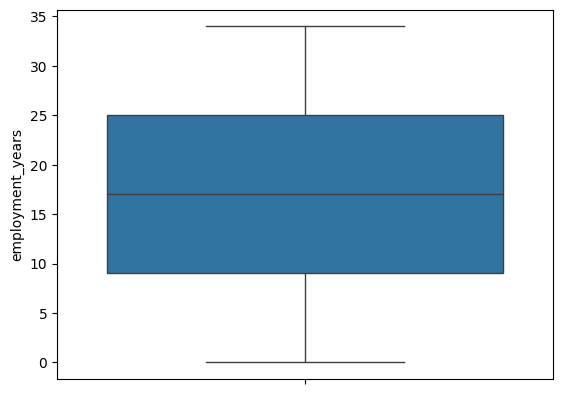

In [ ]:
sns.boxplot(df['employment_years'])

LOAN_AMOUNT

In [ ]:
a = "	loan_amount	payment_history	age	loan_term"

In [ ]:
med = df['loan_amount'].median()
r1 = df['loan_amount'].quantile(0.25)
q3 = df['loan_amount'].quantile(0.75)
iqr = q3 - r1 
Min_loan = r1 - 1.5 * iqr
Max_loan = q3 + 1.5 * iqr

In [ ]:
df['loan_amount'] = np.where(
    df['loan_amount'] < Min_loan,Min_loan,
    np.where(
        df['loan_amount'] > Max_loan,Max_loan,
        df['loan_amount']
    ))

<Axes: ylabel='loan_amount'>

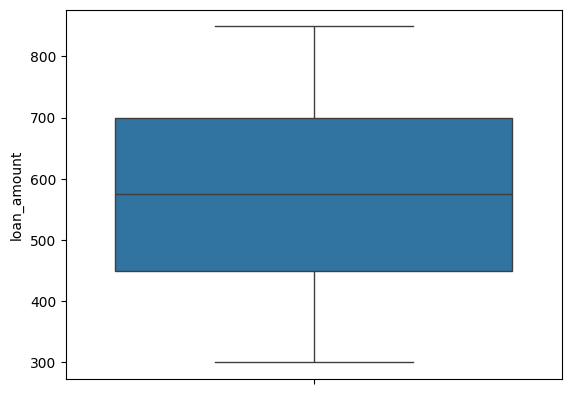

In [ ]:
sns.boxplot(df['loan_amount'])

PAYMENT_HISTORY

In [105]:
df['payment_history'].describe()

,payment_history
count,9000.000000
mean,2.485785
std,1.641445
min,0.000000
25%,1.000000
50%,2.486239
75%,4.000000
max,5.000000


<Axes: ylabel='payment_history'>

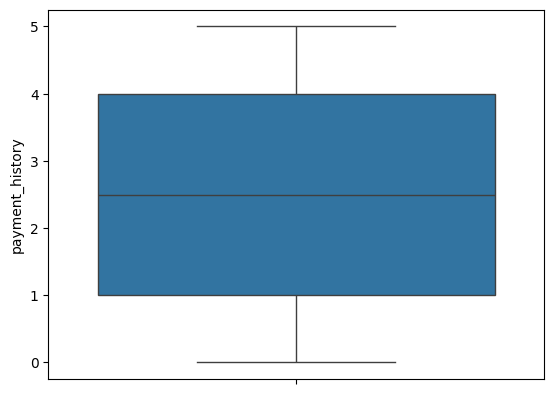

In [107]:
import seaborn as sns
sns.boxplot(df['payment_history'])

AGE

In [109]:
df['age'].describe()

,age
count,9000.000000
mean,44.779667
std,13.338732
min,18.000000
25%,35.000000
50%,46.000000
75%,55.000000
max,69.000000


<Axes: ylabel='age'>

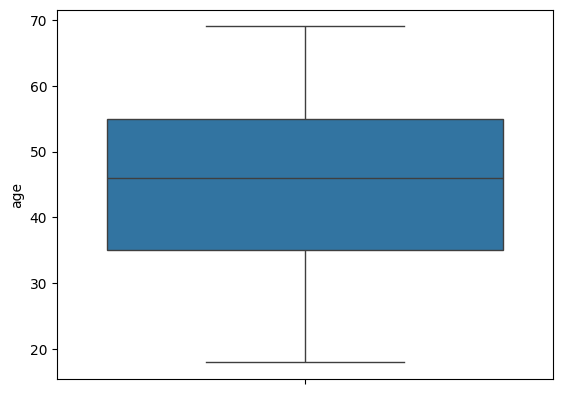

In [116]:
sns.boxplot(df['age'])

LOAN_TERM

<Axes: xlabel='age'>

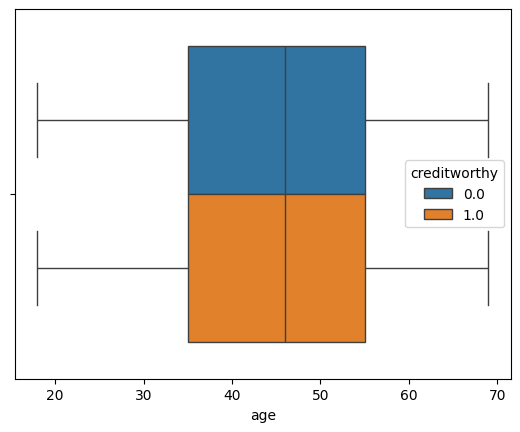

In [120]:
sns.boxplot(data=df, x='age', hue='creditworthy')

In [121]:
df.head(2)

,income,debts,credit_score,employment_years,loan_amount,payment_history,age,loan_term,creditworthy
0,59934.283060,15537.525878,22654.021560,8.0,813.0,3.0,20.0,12.0,1.0
1,47234.713977,38487.292308,25734.127024,17.0,848.0,4.0,65.0,12.0,0.0


TRAIN_TEST_SPLITTING

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [124]:
x = df.drop(columns=['creditworthy'])
y = df['creditworthy']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

FEATURE_SCALING